In [1]:
# Install OpenCV with contrib modules
!pip uninstall opencv-contrib-python opencv-python -y
!pip install opencv-contrib-python


Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 25.2 MB/s eta 0:00:00:00:0100:01


In [2]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision import transforms as T, models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [3]:
class PennFudanDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, mask) for mask in os.listdir(masks_dir) if mask.endswith('.png')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.images[idx]).convert("RGB")
        # Load mask and convert to binary
        mask = Image.open(self.masks[idx])
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)  # Binary mask: 1 for pedestrian, 0 for background

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return image, mask


In [4]:
# Define transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize images and masks
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define inverse transformation for visualization
inverse_transform = T.Compose([
    T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])

# Set dataset paths (adjust the path as per Kaggle's directory structure)
base_path = "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed"
images_path = os.path.join(base_path, "PNGImages")
masks_path = os.path.join(base_path, "PedMasks")

# Initialize dataset
dataset = PennFudanDataset(images_path, masks_path, transform=transform)

# Split dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


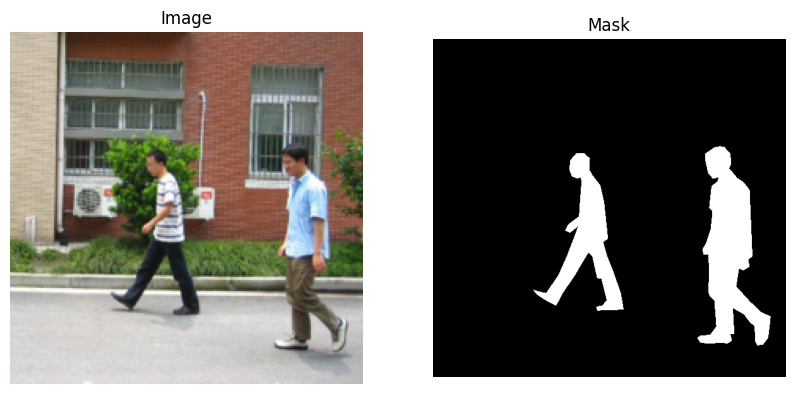

In [5]:
# Function to display images and masks
def visualize_sample(image, mask):
    image = inverse_transform(image).permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Image")
    axes[1].imshow(mask, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("Mask")
    plt.show()

# Display a sample from the training set
sample_image, sample_mask = dataset[0]
visualize_sample(sample_image, sample_mask)


In [29]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.patches as patches
from tqdm import tqdm  # For progress bar

def get_bbox(mask, label):
    """
    Extracts bounding box coordinates from the mask for a given label.
    """
    obj = np.where(mask == label)    
    y1, y2 = obj[0].min(), obj[0].max()
    x1, x2 = obj[1].min(), obj[1].max()
    return {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}

def get_patch(bbox, color='r'):
    """
    Returns a matplotlib rectangle patch for a given bounding box.
    """
    width = bbox['x2'] - bbox['x1']
    height = bbox['y2'] - bbox['y1']
    x, y = bbox['x1'], bbox['y1']
    rectangle = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')
    return rectangle

def get_annotations(mask):
    """
    Extracts all bounding boxes from the mask.
    Assumes that different pedestrians are labeled with unique integer values > 0.
    """
    labels = np.unique(mask)
    annotations = []
    for label in labels:
        if label > 0:  # Exclude background
            annotations.append(get_bbox(mask, label))
    return annotations

def get_iou(bbox1, bbox2):
    """
    Calculates Intersection over Union (IoU) of two bounding boxes.
    """
    x_left = max(bbox1['x1'], bbox2['x1'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bbox1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bbox2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)
    return iou

def compute_offset(gt_bbox, prop_bbox):
    """
    Computes the offset between ground truth and proposed bounding boxes.
    """
    px, py, pw, ph = prop_bbox['x1'], prop_bbox['y1'], prop_bbox['x2'] - prop_bbox['x1'], prop_bbox['y2'] - prop_bbox['y1']
    gx, gy, gw, gh = gt_bbox['x1'], gt_bbox['y1'], gt_bbox['x2'] - gt_bbox['x1'], gt_bbox['y2'] - gt_bbox['y1']
    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = np.log(gw / pw)
    dh = np.log(gh / ph)
    return [dx, dy, dw, dh]

def get_regions(image):
    """
    Generates region proposals using Selective Search.
    """
    selSearch = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    selSearch.setBaseImage(image)
    selSearch.switchToSelectiveSearchFast()
    regions = selSearch.process()
    return regions

def prepare_training_data(images_path, masks_path, max_t=30, max_f=12):
    """
    Prepares training data by generating positive and negative samples.
    Each positive sample corresponds to a pedestrian, and negative samples are background regions.
    
    Args:
        images_path (list): List of image file paths.
        masks_path (list): List of mask file paths.
        max_t (int): Maximum number of positive samples per image.
        max_f (int): Maximum number of negative samples per image.
    
    Returns:
        training_images (list): List of cropped image regions.
        training_labels (list): List of labels (1 for pedestrian, 0 for background).
        training_bboxes (list): List of bounding box offsets.
        training_masks (list): List of cropped segmentation masks.
    """
    training_images = []
    training_labels = []
    training_bboxes = []
    training_masks = []
    
    num_images = len(images_path)
    
    for i in tqdm(range(num_images), desc="Preparing training data"):
        image_path = images_path[i]
        mask_path = masks_path[i]
        
        # Load image and mask
        try:
            image = np.array(Image.open(image_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))
        except Exception as e:
            print(f"Error loading image/mask: {e}")
            continue
        
        annotations = get_annotations(mask)
        regions = get_regions(image)
        
        if len(annotations) == 0:
            print(f"No pedestrians found in image: {image_path}")
            continue
        
        t_counter = 0  # Positive samples
        f_counter = 0  # Negative samples
        
        for region in regions:
            if t_counter >= max_t and f_counter >= max_f:
                break  # Limit samples per image
            
            x, y, w, h = region
            if w < 20 or h < 20:
                continue  # Skip small regions
            
            prop_bbox = {'x1': x, 'y1': y, 'x2': x + w, 'y2': y + h}
            ious = [get_iou(ann, prop_bbox) for ann in annotations]
            max_iou = max(ious) if ious else 0
            max_idx = ious.index(max_iou) if ious else -1
            
            if max_iou > 0.7 and t_counter < max_t:
                # Positive sample
                gt_bbox = annotations[max_idx]
                roi = image[y:y+h, x:x+w]
                roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
                training_images.append(roi)
                training_labels.append(1)
                training_bboxes.append(compute_offset(gt_bbox, prop_bbox))
                
                # Extract and resize the corresponding mask region
                roi_mask = mask[y:y+h, x:x+w]
                roi_mask = (roi_mask > 0).astype(np.float32)  # Binary mask
                roi_mask = cv2.resize(roi_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
                training_masks.append(roi_mask)
                
                t_counter += 1
            elif max_iou < 0.3 and f_counter < max_f:
                # Negative sample
                roi = image[y:y+h, x:x+w]
                roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
                training_images.append(roi)
                training_labels.append(0)
                training_bboxes.append([0, 0, 0, 0])  # No offset for background
                
                # For negative samples, masks are all zeros
                roi_mask = np.zeros((h, w), dtype=np.float32)
                roi_mask = cv2.resize(roi_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
                training_masks.append(roi_mask)
                
                f_counter += 1
                
    return training_images, training_labels, training_bboxes, training_masks


In [30]:
import os
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import torchvision.transforms as T

# Define dataset paths (adjust the path as per Kaggle's directory structure)
base_path = "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed"
images_dir = os.path.join(base_path, "PNGImages")
masks_dir = os.path.join(base_path, "PedMasks")

# Generate sorted lists of image and mask file paths
images_path = sorted([
    os.path.join(images_dir, fname) for fname in os.listdir(images_dir) 
    if fname.endswith(".png") and os.path.isfile(os.path.join(images_dir, fname))
])

masks_path = sorted([
    os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir) 
    if fname.endswith(".png") and os.path.isfile(os.path.join(masks_dir, fname))
])

# Prepare training data
training_images, training_labels, training_bboxes, training_masks = prepare_training_data(images_path, masks_path)

print(f"Total training images: {len(training_images)}")
print(f"Total training labels: {len(training_labels)}")
print(f"Total training bounding boxes: {len(training_bboxes)}")
print(f"Total training masks: {len(training_masks)}")


Preparing training data: 100%|██████████| 170/170 [08:01<00:00,  2.83s/it]

Total training images: 3048
Total training labels: 3048
Total training bounding boxes: 3048
Total training masks: 3048


In [31]:
# Define transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define inverse transformation for visualization
inverse_transform = T.Compose([
    T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])
# Apply transformations and convert to tensors
images = torch.stack([transform(img) for img in training_images])
labels = torch.tensor(training_labels, dtype=torch.long)
bboxes = torch.tensor(training_bboxes, dtype=torch.float32)
masks = torch.tensor(training_masks, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

print(f"Images shape: {images.shape}")        # [N, 3, 224, 224]
print(f"Labels shape: {labels.shape}")        # [N]
print(f"Bounding Boxes shape: {bboxes.shape}")  # [N, 4]
print(f"Masks shape: {masks.shape}")          # [N, 1, 224, 224]

Images shape: torch.Size([3048, 3, 224, 224])
Labels shape: torch.Size([3048])
Bounding Boxes shape: torch.Size([3048, 4])
Masks shape: torch.Size([3048, 1, 224, 224])


/tmp/ipykernel_30/2406863360.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.tensor(training_masks, dtype=torch.float32).unsqueeze(1)  # Add channel dimension


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


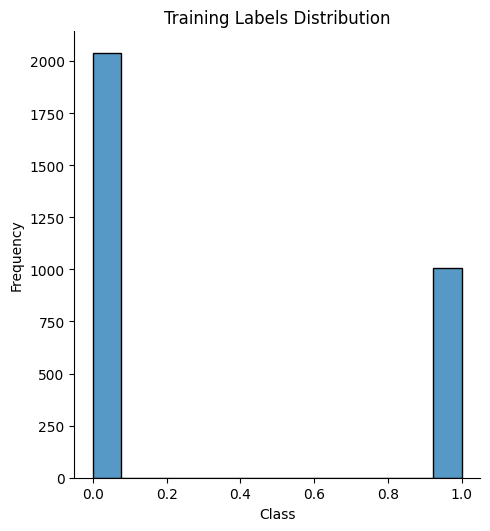

In [32]:
#Visualize Training Data Distribution
sns.displot(training_labels)
plt.title("Training Labels Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()



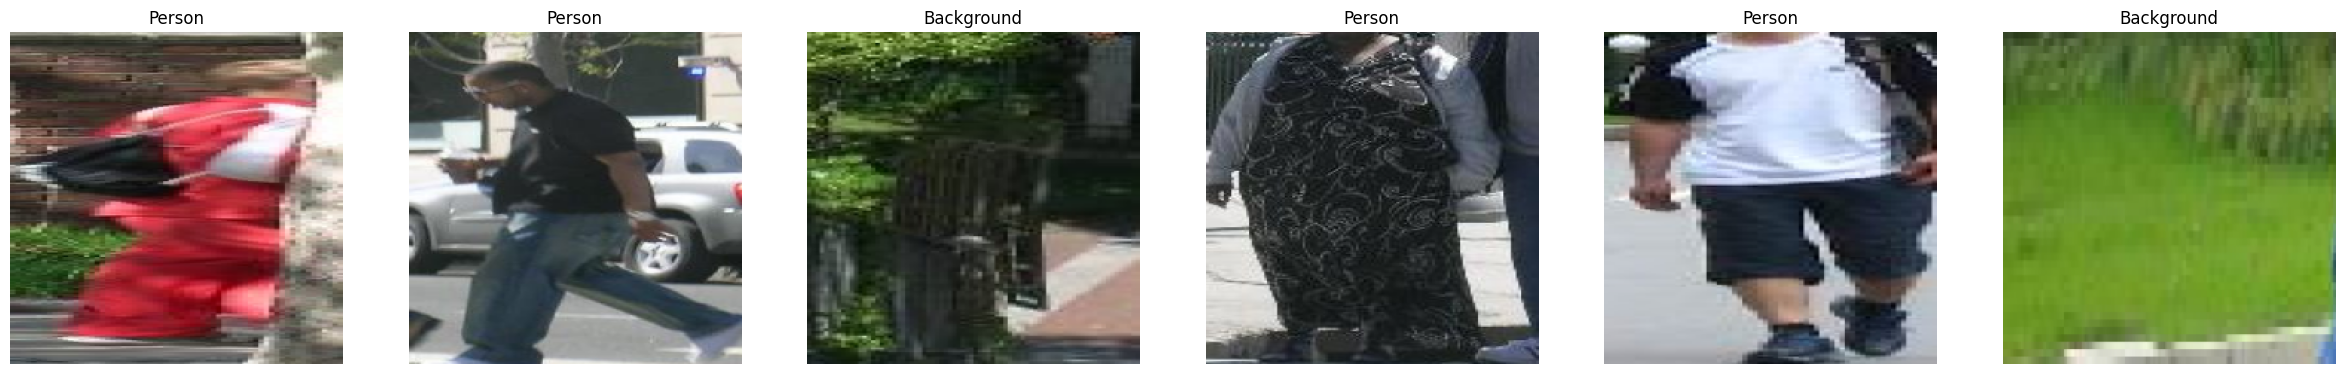

In [33]:
#Display Sample Training Images

indices = np.random.randint(len(training_images), size=(6))
fig, axes = plt.subplots(1, 6, figsize=(30, 5))
for i in range(6):
    axes[i].imshow(training_images[indices[i]])
    axes[i].axis('off')
    axes[i].set_title("Person" if training_labels[indices[i]] == 1 else "Background")
plt.show()


In [34]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create a TensorDataset
dataset = TensorDataset(images, labels, bboxes, masks)

# Split into training and testing sets
test_size = int(0.2 * len(dataset))  # 20% for testing
train_size = len(dataset) - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_set)}")
print(f"Testing samples: {len(test_set)}")



Training samples: 2439
Testing samples: 609


# Model 

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class RCNNWithSegmentation(nn.Module):
    def __init__(self, num_classes=2):
        super(RCNNWithSegmentation, self).__init__()
        
        # Feature extractor (VGG16)
        backbone = models.vgg16(pretrained=True)
        self.features = backbone.features  # Extract convolutional features
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
        )
        self.classifier = nn.Linear(4096, num_classes)
        
        # Bounding box regression head
        self.regressor = nn.Linear(4096, 4)
        
        # Segmentation (Mask) head
        self.mask_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Output mask probabilities
        )
    
    def forward(self, x):
        # Feature extraction
        features = self.features(x)  # Shape: [batch, 512, H/16, W/16]
        
        # Classification and Regression
        pooled = self.avgpool(features)  # Shape: [batch, 512, 7, 7]
        pooled = torch.flatten(pooled, 1)  # Shape: [batch, 512*7*7=25088]
        fc_output = self.fc(pooled)  # Shape: [batch, 4096]
        
        logits = self.classifier(fc_output)  # Shape: [batch, num_classes]
        bbox_reg = self.regressor(fc_output)  # Shape: [batch, 4]
        
        # Mask prediction
        masks = self.mask_head(features)  # Shape: [batch, 1, H/4, W/4]
        masks = F.interpolate(masks, size=(224, 224), mode='bilinear', align_corners=False)  # Upsample to original size
        
        return logits, bbox_reg, masks


In [36]:
# Initialize the model
model = RCNNWithSegmentation(num_classes=2)  # 2 classes: Background and Pedestrian
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Print the model architecture
print(model)

for param in model.features.parameters():
    param.requires_grad = False


# Define loss functions
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.SmoothL1Loss()
mask_loss_fn = nn.BCELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RCNNWithSegmentation(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

In [37]:
from tqdm import tqdm

def train_model(dataloader, model, classification_loss_fn, regression_loss_fn, mask_loss_fn, optimizer, callback=None):
    """
    Trains the model for one epoch.
    """
    model.train()
    total_loss = 0.0
    for batch_idx, (images, labels, bboxes, masks) in enumerate(tqdm(dataloader, desc="Training")):
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)
        masks = masks.to(device)
        
        # Forward pass
        logits, bbox_reg, predicted_masks = model(images)
        
        # Compute losses
        classification_loss = classification_loss_fn(logits, labels)
        regression_loss = regression_loss_fn(bbox_reg, bboxes)
        mask_loss = mask_loss_fn(predicted_masks, masks)
        
        # Total loss
        loss = classification_loss + regression_loss + mask_loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Callback for logging
        if callback and batch_idx % 10 == 0:
            callback(loss.item(), batch_idx)
    
    average_loss = total_loss / len(dataloader)
    return average_loss

def test_model(dataloader, model, classification_loss_fn, regression_loss_fn, mask_loss_fn):
    """
    Evaluates the model on the test set.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, labels, bboxes, masks) in enumerate(tqdm(dataloader, desc="Testing")):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            masks = masks.to(device)
            
            # Forward pass
            logits, bbox_reg, predicted_masks = model(images)
            
            # Compute losses
            classification_loss = classification_loss_fn(logits, labels)
            regression_loss = regression_loss_fn(bbox_reg, bboxes)
            mask_loss = mask_loss_fn(predicted_masks, masks)
            
            # Total loss
            loss = classification_loss + regression_loss + mask_loss
            total_loss += loss.item()
    
    average_loss = total_loss / len(dataloader)
    return average_loss

def log_callback(loss, batch_idx):
    """
    Logs the loss at specific intervals.
    """
    if batch_idx % 10 == 0:
        print(f"Batch {batch_idx}, Loss: {loss:.4f}")

In [38]:
# Number of epochs
num_epochs = 10

# Lists to store loss history
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    print(f"----- Epoch {epoch+1}/{num_epochs} -----")
    train_loss = train_model(train_loader, model, classification_loss_fn, regression_loss_fn, mask_loss_fn, optimizer, callback=log_callback)
    test_loss = test_model(test_loader, model, classification_loss_fn, regression_loss_fn, mask_loss_fn)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}")


----- Epoch 1/10 -----


Training:   1%|▏         | 1/77 [00:01<02:14,  1.77s/it]

Batch 0, Loss: 1.3003


Training:  14%|█▍        | 11/77 [00:03<00:14,  4.56it/s]

Batch 10, Loss: 0.4122


Training:  27%|██▋       | 21/77 [00:05<00:11,  4.81it/s]

Batch 20, Loss: 0.3835


Training:  40%|████      | 31/77 [00:07<00:09,  4.82it/s]

Batch 30, Loss: 0.1730


Training:  53%|█████▎    | 41/77 [00:10<00:07,  4.80it/s]

Batch 40, Loss: 0.1864


Training:  66%|██████▌   | 51/77 [00:12<00:05,  4.85it/s]

Batch 50, Loss: 0.2600


Training:  79%|███████▉  | 61/77 [00:14<00:03,  4.87it/s]

Batch 60, Loss: 0.2735


Training:  92%|█████████▏| 71/77 [00:16<00:01,  4.81it/s]

Batch 70, Loss: 0.2071


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Epoch 1, Training Loss: 0.6976, Testing Loss: 0.1891
----- Epoch 2/10 -----


Training:   1%|▏         | 1/77 [00:00<00:27,  2.77it/s]

Batch 0, Loss: 0.5344


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.77it/s]

Batch 10, Loss: 0.2423


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.81it/s]

Batch 20, Loss: 0.1603


Training:  40%|████      | 31/77 [00:06<00:09,  4.75it/s]

Batch 30, Loss: 0.1783


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.75it/s]

Batch 40, Loss: 0.1720


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.73it/s]

Batch 50, Loss: 0.1076


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.77it/s]

Batch 60, Loss: 0.1795


Training:  92%|█████████▏| 71/77 [00:15<00:01,  4.76it/s]

Batch 70, Loss: 0.0842


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Epoch 2, Training Loss: 0.1663, Testing Loss: 0.1630
----- Epoch 3/10 -----


Training:   1%|▏         | 1/77 [00:00<00:30,  2.46it/s]

Batch 0, Loss: 0.0729


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.73it/s]

Batch 10, Loss: 0.1185


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.78it/s]

Batch 20, Loss: 0.1210


Training:  40%|████      | 31/77 [00:06<00:09,  4.76it/s]

Batch 30, Loss: 0.1615


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.81it/s]

Batch 40, Loss: 0.0986


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.81it/s]

Batch 50, Loss: 0.0630


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.83it/s]

Batch 60, Loss: 0.1751


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.84it/s]

Batch 70, Loss: 0.0825


Testing: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Epoch 3, Training Loss: 0.1146, Testing Loss: 0.1690
----- Epoch 4/10 -----


Training:   1%|▏         | 1/77 [00:00<00:28,  2.66it/s]

Batch 0, Loss: 0.0796


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.77it/s]

Batch 10, Loss: 0.0902


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.79it/s]

Batch 20, Loss: 0.0820


Training:  40%|████      | 31/77 [00:06<00:09,  4.82it/s]

Batch 30, Loss: 0.2727


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.84it/s]

Batch 40, Loss: 0.0442


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.86it/s]

Batch 50, Loss: 0.1137


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.77it/s]

Batch 60, Loss: 0.1125


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.83it/s]

Batch 70, Loss: 0.0534


Testing: 100%|██████████| 20/20 [00:03<00:00,  6.04it/s]


Epoch 4, Training Loss: 0.0855, Testing Loss: 0.1670
----- Epoch 5/10 -----


Training:   1%|▏         | 1/77 [00:00<00:28,  2.71it/s]

Batch 0, Loss: 0.0625


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.81it/s]

Batch 10, Loss: 0.0551


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.77it/s]

Batch 20, Loss: 0.0596


Training:  40%|████      | 31/77 [00:06<00:09,  4.79it/s]

Batch 30, Loss: 0.0725


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.81it/s]

Batch 40, Loss: 0.0332


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.77it/s]

Batch 50, Loss: 0.0563


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.80it/s]

Batch 60, Loss: 0.1034


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.78it/s]

Batch 70, Loss: 0.0604


Testing: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


Epoch 5, Training Loss: 0.0654, Testing Loss: 0.1781
----- Epoch 6/10 -----


Training:   1%|▏         | 1/77 [00:00<00:27,  2.73it/s]

Batch 0, Loss: 0.0504


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.79it/s]

Batch 10, Loss: 0.0619


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.80it/s]

Batch 20, Loss: 0.0749


Training:  40%|████      | 31/77 [00:06<00:09,  4.82it/s]

Batch 30, Loss: 0.0512


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.80it/s]

Batch 40, Loss: 0.0404


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.80it/s]

Batch 50, Loss: 0.0465


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.80it/s]

Batch 60, Loss: 0.0495


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.77it/s]

Batch 70, Loss: 0.0596


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Epoch 6, Training Loss: 0.0533, Testing Loss: 0.1666
----- Epoch 7/10 -----


Training:   1%|▏         | 1/77 [00:00<00:28,  2.70it/s]

Batch 0, Loss: 0.0530


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.77it/s]

Batch 10, Loss: 0.0535


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.79it/s]

Batch 20, Loss: 0.0454


Training:  40%|████      | 31/77 [00:06<00:09,  4.77it/s]

Batch 30, Loss: 0.0215


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.75it/s]

Batch 40, Loss: 0.0553


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.78it/s]

Batch 50, Loss: 0.0537


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.80it/s]

Batch 60, Loss: 0.0310


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.80it/s]

Batch 70, Loss: 0.0503


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Epoch 7, Training Loss: 0.0526, Testing Loss: 0.1853
----- Epoch 8/10 -----


Training:   1%|▏         | 1/77 [00:00<00:28,  2.68it/s]

Batch 0, Loss: 0.0718


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.82it/s]

Batch 10, Loss: 0.0652


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.83it/s]

Batch 20, Loss: 0.0325


Training:  40%|████      | 31/77 [00:06<00:09,  4.85it/s]

Batch 30, Loss: 0.0350


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.81it/s]

Batch 40, Loss: 0.0472


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.84it/s]

Batch 50, Loss: 0.0566


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.83it/s]

Batch 60, Loss: 0.0409


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.81it/s]

Batch 70, Loss: 0.0867


Testing: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


Epoch 8, Training Loss: 0.0490, Testing Loss: 0.2355
----- Epoch 9/10 -----


Training:   1%|▏         | 1/77 [00:00<00:28,  2.67it/s]

Batch 0, Loss: 0.0990


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.81it/s]

Batch 10, Loss: 0.0519


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.83it/s]

Batch 20, Loss: 0.0499


Training:  40%|████      | 31/77 [00:06<00:09,  4.83it/s]

Batch 30, Loss: 0.0423


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.84it/s]

Batch 40, Loss: 0.0790


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.80it/s]

Batch 50, Loss: 0.0548


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.81it/s]

Batch 60, Loss: 0.0877


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.80it/s]

Batch 70, Loss: 0.0588


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s]


Epoch 9, Training Loss: 0.0556, Testing Loss: 0.1955
----- Epoch 10/10 -----


Training:   1%|▏         | 1/77 [00:00<00:29,  2.56it/s]

Batch 0, Loss: 0.0534


Training:  14%|█▍        | 11/77 [00:02<00:13,  4.78it/s]

Batch 10, Loss: 0.0365


Training:  27%|██▋       | 21/77 [00:04<00:11,  4.82it/s]

Batch 20, Loss: 0.0466


Training:  40%|████      | 31/77 [00:06<00:09,  4.82it/s]

Batch 30, Loss: 0.0587


Training:  53%|█████▎    | 41/77 [00:08<00:07,  4.80it/s]

Batch 40, Loss: 0.0476


Training:  66%|██████▌   | 51/77 [00:10<00:05,  4.77it/s]

Batch 50, Loss: 0.0299


Training:  79%|███████▉  | 61/77 [00:12<00:03,  4.76it/s]

Batch 60, Loss: 0.0350


Training:  92%|█████████▏| 71/77 [00:14<00:01,  4.82it/s]

Batch 70, Loss: 0.0284


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]

Epoch 10, Training Loss: 0.0434, Testing Loss: 0.1779


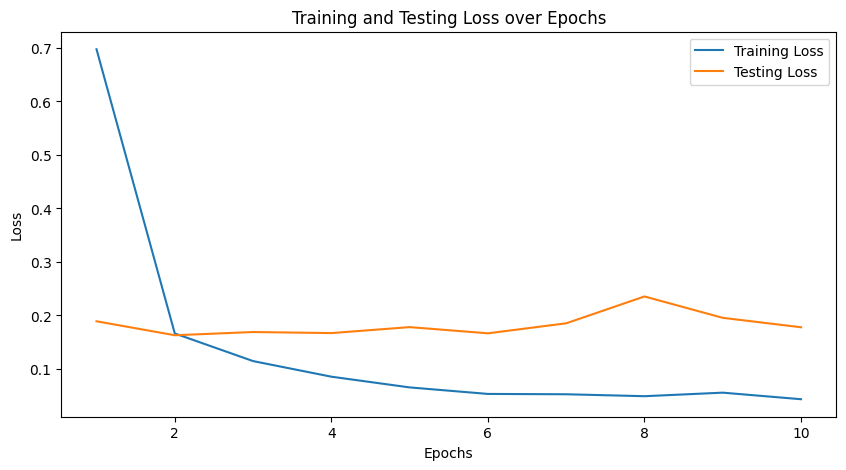

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_metrics(dataloader, model, threshold=0.5):
    """
    Evaluates precision, recall, F1-score, and confusion matrix for classification.
    """
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels, bboxes, masks in tqdm(dataloader, desc="Evaluating Metrics"):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            masks = masks.to(device)
            
            # Forward pass
            logits, bbox_reg, predicted_masks = model(images)
            
            # Classification predictions
            preds = torch.argmax(logits, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Pedestrian'], yticklabels=['Background', 'Pedestrian'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Evaluating Metrics: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Precision: 0.9855
Recall: 0.9855
F1-Score: 0.9855


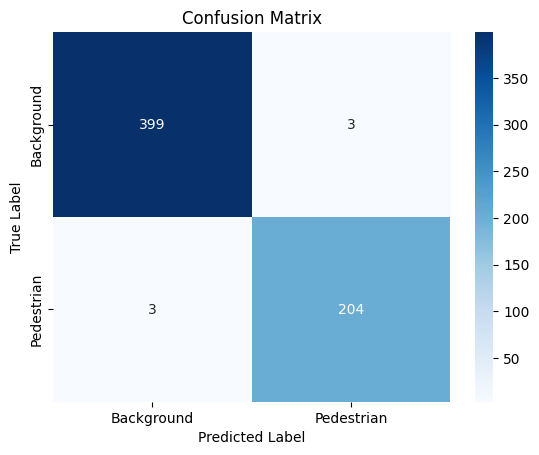

In [43]:
evaluate_metrics(test_loader, model, threshold=0.5)


In [44]:
def visualize_segmentation(model, dataloader, num_images=5, threshold=0.5):
    """
    Visualizes predicted masks alongside the original images and ground truth masks.
    """
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels, bboxes, masks) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            masks = masks.to(device)
            logits, bbox_reg, predicted_masks = model(images)
            
            # Apply threshold to predicted masks
            pred_masks = (predicted_masks > threshold).float()
            
            for i in range(images.size(0)):
                if batch_idx * dataloader.batch_size + i >= num_images:
                    return
                image = images[i].cpu()
                image = inverse_transform(image).permute(1, 2, 0).numpy()
                mask = masks[i].squeeze().cpu().numpy()
                pred_mask = pred_masks[i].squeeze().cpu().numpy()
                
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(image)
                axes[0].set_title("Original Image")
                axes[0].axis('off')
                
                axes[1].imshow(mask, cmap='gray')
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis('off')
                
                axes[2].imshow(image)
                axes[2].imshow(pred_mask, cmap='jet', alpha=0.5)
                axes[2].set_title("Predicted Mask")
                axes[2].axis('off')
                
                plt.show()
            break  # Display only the first batch


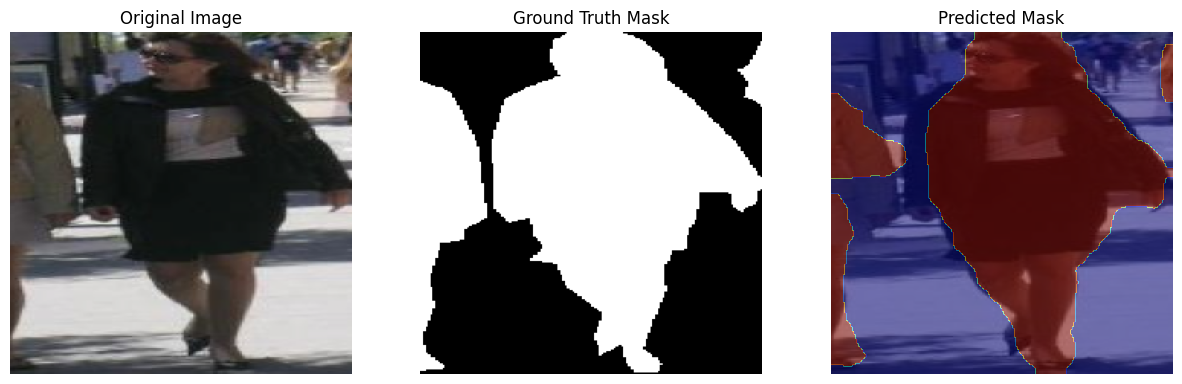

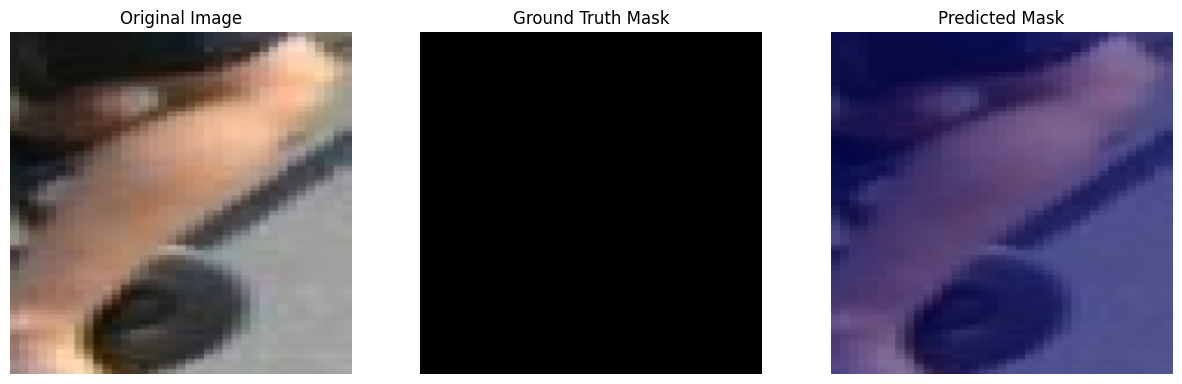

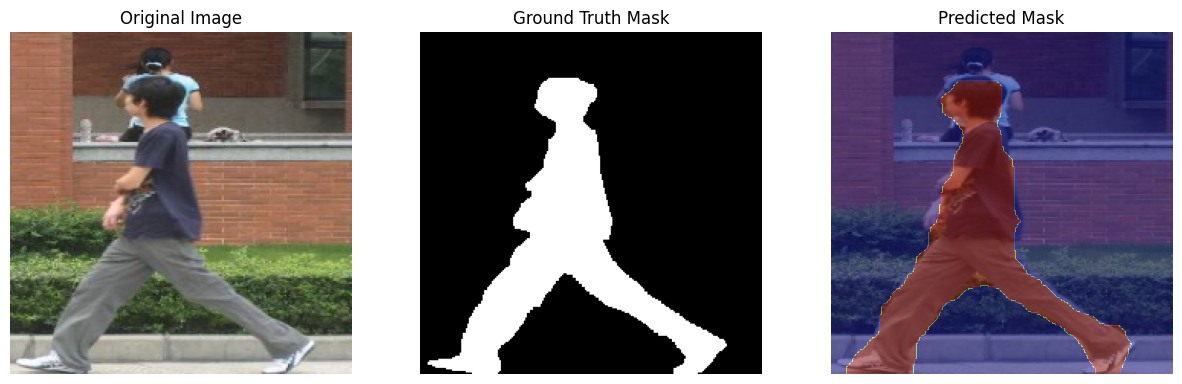

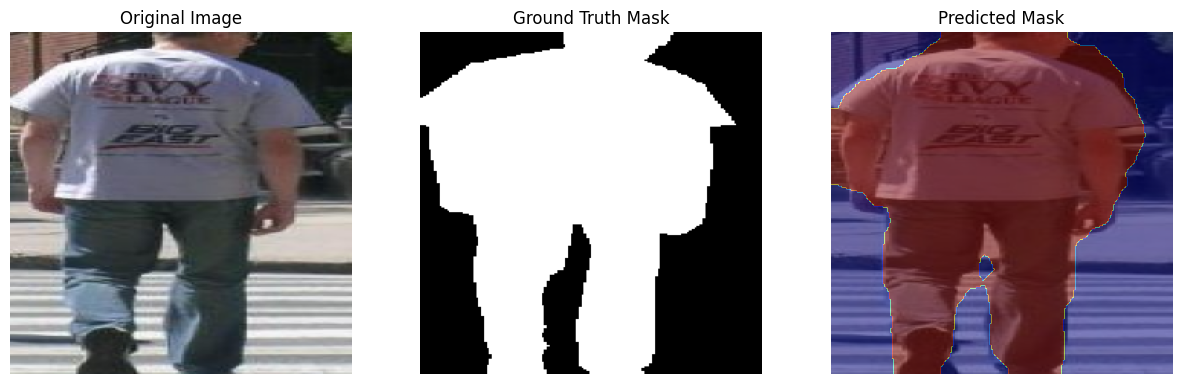

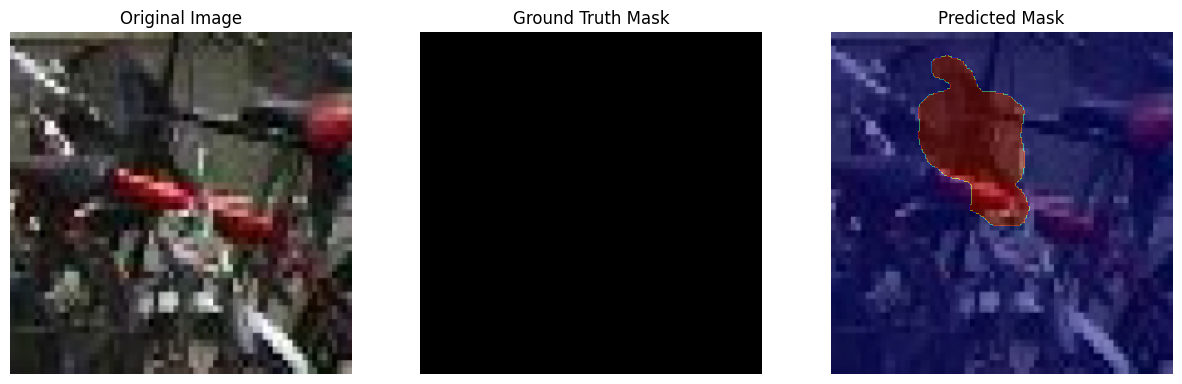

In [45]:
# Visualize segmentation results
visualize_segmentation(model, test_loader, num_images=5, threshold=0.5)


In [46]:
# Define the path where you want to save the model
MODEL_PATH = 'rcnn_with_segmentation_state_dict.pth'

# Save the state_dict
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model state_dict saved to {MODEL_PATH}")


Model state_dict saved to rcnn_with_segmentation_state_dict.pth
